# Microscopy Image Enhancement (Part I)

In [1]:

from tk import allen_demo as demo
from tk import experiment
from tensorflow.contrib.eager.python import tfe


Instructions for updating:
Use the retry module or similar alternatives.


## Overview

In this post we’ll explore the problem of resolution up-sampling mouse brain microscopy images. Beyond curiosity's sake this is a pretty worthwhile problem space given the role of tissue imaging in a variety of health applications including cancer diagnostics as well as basic drug development.

We'll do this using an Image Transformer model built using the [tensor2tensor](https://github.com/tensorflow/tensor2tensor) framework which will be trained on Google Container Engine by way of the [Kubeflow](https://github.com/kubeflow) framework (and a [custom Python wrapper](https://github.com/cwbeitel/tk) to simplify the task of launching jobs).

<br>


## Background

*Kubeflow*

Kubeflow is a full stack of open source (and very modern) computational infrastructure components for both machine learning research and production on large pools of compute resources. In case you aren't familiar with Kubernetes, you can learn more [here](https://www.youtube.com/watch?v=4ht22ReBjno)). For more on Kubeflow, check out the [docs](https://www.kubeflow.org/) or this [talk](https://www.youtube.com/watch?v=I6iMznIYwM8) from Kubecon 2018.

*Tensor2tensor*

Tensor2tensor is a powerful and battle-tested framework for expressing problems and models as well as for training with best practices. Check out [this coffee chat](https://www.youtube.com/watch?v=O2UvKxaOH7c) with Lucasz Kaiser or the [project readme](https://github.com/tensorflow/tensor2tensor) for a nice overview.

<br>

## Dataset

First, let’s get familiar with our dataset and the problem we will be working to solve.

#### Examining the raw data

We'll be working with sub-images of a very large brightfield image of a saggital mouse brain tissue cross-section. We can obtain one from the Allen Institute API with the following:

Local example image already exists, skipping download.


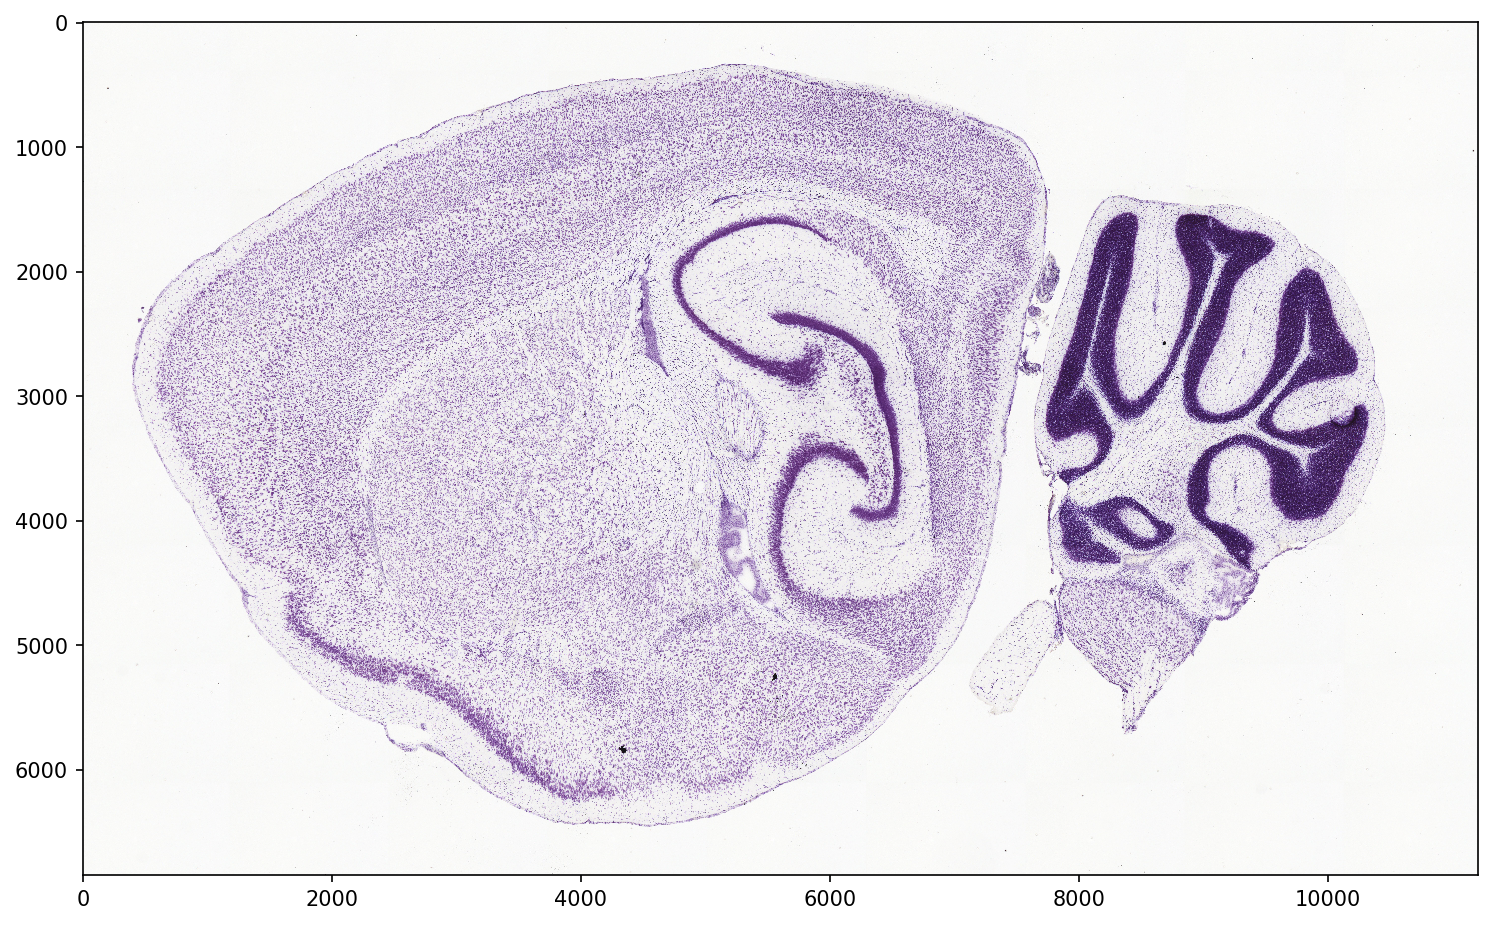

In [61]:

import matplotlib.pyplot as plt
import numpy as np

img = demo.load_example_image()

plt.figure(num=None, figsize=(12, 12), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(np.uint8(img))


Image Credit: Allen Institute

Let's take a look at a portion of the image at various magnifications.

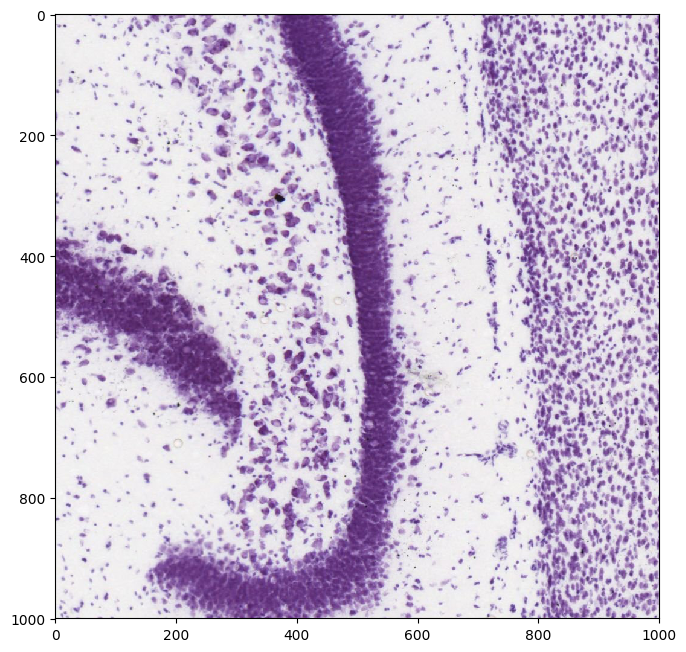

In [3]:

plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.uint8(img[3000:4000,6000:7000]))


Image Credit: Allen Institute

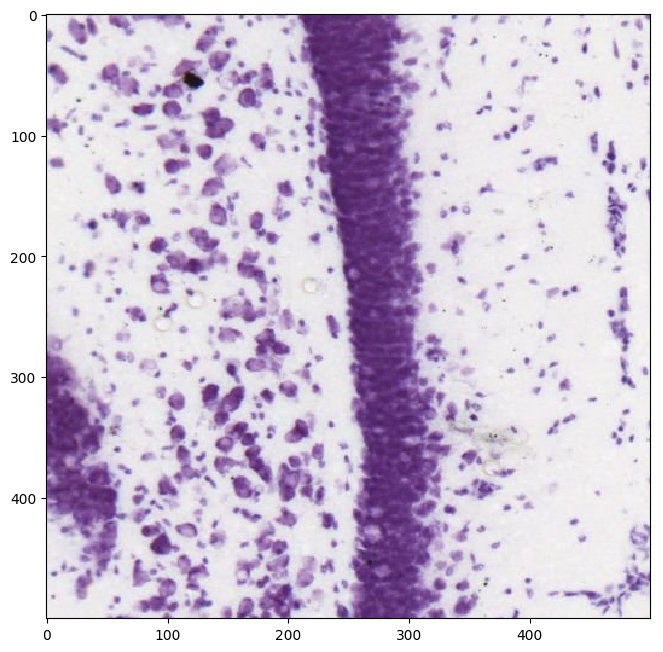

In [5]:

plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.uint8(img[3250:3750,6250:6750]))


Image Credit: Allen Institute

Looks like we have some fairly high-resolution images that allow us to make out the shapes and distinctions between the somas of various neurons. If we had a lower-resolution dataset or perhaps a dataset with more noise we might want to be able to apply a model to improve its resolution to be on par with what is shown above.

#### Generating examples

Next we'll proceed with turning raw data into examples we can use for training. This will make use of a problem definition I recently contributed to the tensor2tensor data_generators which you can check out [here](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/data_generators/allen_brain.py).

Our neural network will attempt to learn a mapping between an input image and a target image. The problem we'll be working with takes the raw image and splits it up into 32px by 32px sub-images - we'll use these as our targets. We'll also use a down-sampled 8px by 8px version of these as our inputs.

In the following we'll import that and call the generate_data method, providing the appropriate tmp and data dir paths (the former being the directory to which raw data will be downloaded and the latter being the directory to which TFRecord training examples will be generated).

In [2]:

from tensor2tensor.data_generators.allen_brain import Img2imgAllenBrainDim8to32

data_dir = "/mnt/nfs-east1-d/data"
tmp_dir = "/mnt/nfs-east1-d/tmp"

problem_object = Img2imgAllenBrainDim8to32()

problem_object.generate_data(data_dir, tmp_dir)


INFO:tensorflow:Skipping generator because outputs files exist


[2018-09-23 20:39:41,002] Skipping generator because outputs files exist


INFO:tensorflow:Skipping generator because outputs files exist


[2018-09-23 20:39:41,007] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-09-23 20:39:41,014] Skipping shuffle because output files exist


That will take at least an hour or so, depending on the speed of your internet connection. Once it's finished you'll be able to iterate over examples using tf.eager:

INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-09-23 20:40:08,880] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-23 20:40:08,946] partition: 0 num_data_files: 100


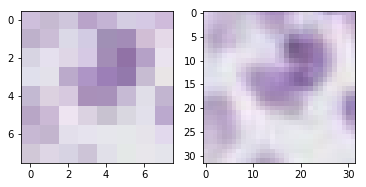

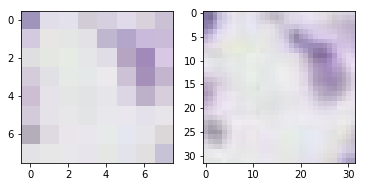

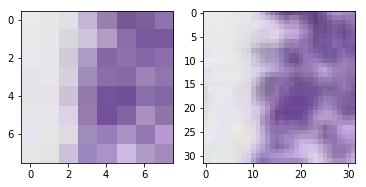

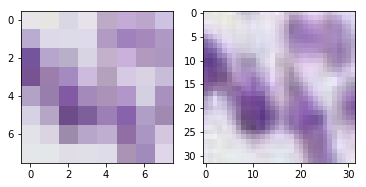

In [6]:

demo.show_random_examples(problem_object, data_dir, num=4)


## Training the stock model

Let's start by training the stock Tensor2Tensor Image Transformer model. Check out the paper [here](https://arxiv.org/abs/1802.05751).

We'll be using [an early (unsupported) draft](https://github.com/cwbeitel/tk) of a library I built to simplify the process of configuring and launching training jobs on Kubernetes + Kubeflow. In the somewhat near future it looks like this purpose will be well served by [@wbuchwalter](https://github.com/wbuchwalter)'s [Faring](https://github.com/wbuchwalter/fairing) which should be generalized beyond TensorFlow and provide more robust support for various [interesting hyperparameter tuning strategies](https://github.com/wbuchwalter/fairing/blob/master/examples/population-based-training/main.py).

#### Training

Great now let's do a long run on a node with multiple GPUs and a model of reasonable size.

In [ ]:

args = _configure_experiment("allen-ngpu8",
                             problem="img2img_allen_brain_dim8to32",
                             num_gpu_per_worker=8,
                             hparams_set="img2img_transformer2d_tiny",
                             model="img2img_transformer",
                             extra_hparams={
                               "batch_size": 18,
                             },
                             num_steps=15000)

job = experiment.T2TExperiment(**args)
job.run()


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-24 17:28:28,243] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-09-24 17:28:29,425] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-24 17:28:36,756] Finished loading event data for comparison.


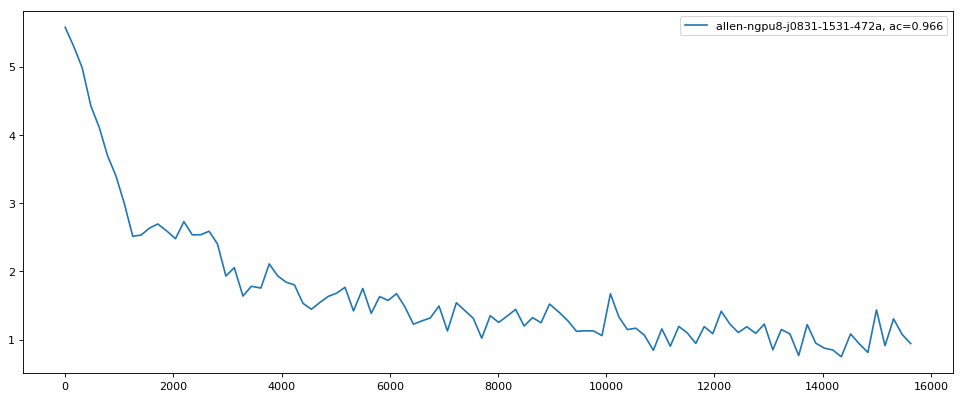

In [12]:

experiment_data = demo.event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-ngpu8*")
demo.show_experiment_loss(experiment_data)


Our model does not seem to converge smoothly but rather continues to vary significantly. This could be due to using an overly-small batch size. While this is the largest batch size that was able to train on our current hardware (an NVIDIA K80 GPU), we might try distributing over multiple machines with 8x GPUs thereby increasing the effective batch size by the multiplicity of that distribution.

We might also consider using a different architecture that scales in image size more efficiently than the Image Transformer model (I believe such as the U-Net).

#### Qualitative analysis

Now that our model is trained we can take a look at its predictions and see how well it's doing and how it might be improved. Imaging problems are great in this regard because we can visually see where the problem is under-performing to gain insight into how to improve it. This is true of other modalities but harder with those that can't be readily visualized like high-dimensional non-visual time-series data.

In [2]:

from tensor2tensor.utils import trainer_lib
from tensor2tensor import problems
from tensor2tensor.utils import registry
import tensorflow as tf
Modes = tf.estimator.ModeKeys

hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/allen-ngpu8/allen-ngpu8-j0831-1531-472a/model.ckpt-4586"


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-09-24 16:59:50,180] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-09-24 16:59:50,185] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-24 16:59:50,276] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-09-24 16:59:53,373] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-09-24 16:59:53,377] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-09-24 16:59:53,380] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-09-24 16:59:54,701] Transforming body output with identity_modality.top


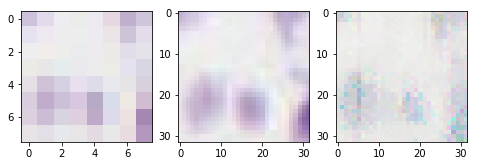

In [3]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)
    

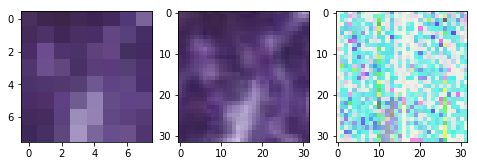

In [4]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


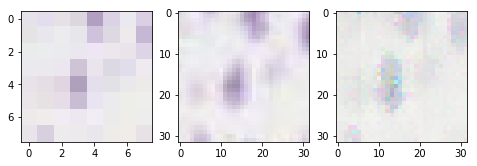

In [5]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


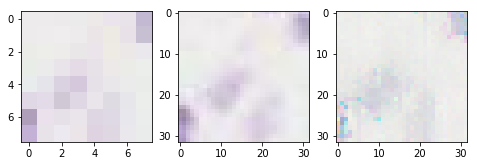

In [6]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


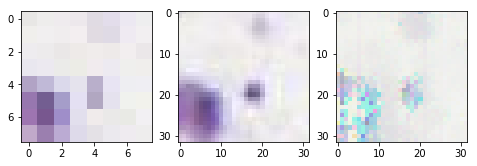

In [7]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


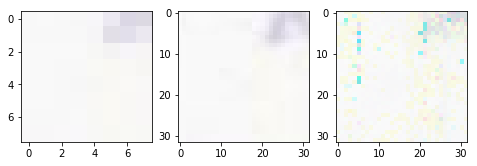

In [8]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


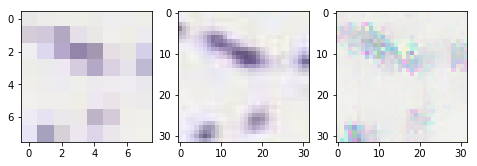

In [9]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


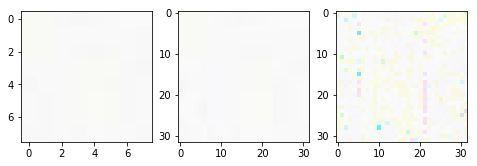

In [10]:

_ = demo.predict_ith(1234, ckpt_path, dataset, model)


Interesting. First of all, in many cases our model does seem to be inferring something of higher-resolution from the lower-resolution input that looks approximately correct in some sense. But with the presence of distinctly pink and teal pixels. It seems the second example above is an extreme case of this and in general it tends to happen in the darker portions of the image.

Additionally there appear to be vertical streaks in regular positions across all of the examples.

There are multiple directions to go from here.

#### Larger model

First of all, the model we used for this problem was very small, coming from the [img2img_transformer_tiny](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/image_transformer_2d.py#L887) hparam set, which seems to be primarily meant for testing and debugging. Here's its specification:

```python
def img2img_transformer_tiny():
  """Tiny params."""
  hparams = img2img_transformer2d_base()
  hparams.num_hidden_layers = 2
  hparams.hidden_size = 128
  hparams.batch_size = 4
  hparams.max_length = 128
  hparams.attention_key_channels = hparams.attention_value_channels = 0
  hparams.filter_size = 128
  hparams.num_heads = 1
  hparams.pos = "timing"
  return hparams
```

In contrast, for example, [img2img_transformer2d_n24](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/image_transformer_2d.py#L833) uses the following:
```python
def img2img_transformer2d_n24():
  """Set of hyperparameters."""
  hparams = img2img_transformer2d_base()
  hparams.batch_size = 1
  hparams.hidden_size = 1024
  hparams.filter_size = 2048
  hparams.layer_prepostprocess_dropout = 0.2
  hparams.num_decoder_layers = 8
  hparams.query_shape = (8, 16)
  hparams.memory_flange = (8, 32)
  return hparams
```

#### Normalization

We should probably normalize our examples to have zero norm and unit variance. This should be done using the mean and variance of the dataset as a whole which can be approximated using a random sample of sub-images across different slices. Currently examples come directly from the Allen Inst. API which serves images which are of course not normalized.

#### Better loss function

We might also explore adding an adversarial loss. The above visual features are quite obvious for us to detect - simply being the presence of pixels of particular colors or the presence of distinct visual lines. It is reasonable to expect that a discriminator network could learn to detect these features. In doing so it would be interesting to extend the existing loss, which seems to perform reasonably well, with the adversarial loss (i.e. use a hybrid).

#### Smaller up-sampling ratio

We might explore a smaller up-sampling ratio. In this case, this ratio (from 8px by 8px to 32px by 32px) is 4x. Perhaps we could either consider only an up-sampling ratio of 1.25x or consider a schedule of increasing this ratio throughout training.

#### Larger effective batch size

As mentioned above, one direction going forward would be to distribute training over multiple 8x GPU machines, thereby increasing the effective batch size (and presumably the smoothness of the optimization) even further. Increasing the batch size of course doesn't always lead to improvements in performance but in this case our effective batch size is still rather small - 18*8 = 144.

With that said, the pix2pix work by Isola et al. (2017) used a batch size of only 10 when comparing with an encoder-decoder architecture. Either a small batch size may be sufficient in the case of our current architecture or a change in architecture might permit a reduction in batch size.

#### Consider a different architecture

More generally than in regard to the batch size question - Isola et al. (2017) have reported good results using U-Nets for hybrid-loss adversarial image translation, e.g. [pix2pix](https://github.com/phillipi/pix2pix) with patch sizes up to 284x284 on a Titan X GPU (12GB memory). Such an approach would also be worth exploring for the sake of comparison.

#### Simplify the problem

We could try simplifying the problem by converting these images to greyscale. Although the stain we're using has a purple color, it is in effect a binary indicator.


## To be continued...

That's all for Part I of our continuing series. Stay tuned next week when see how the above improves with normalization and perhaps an alternative loss or architecture.

## Normalization


So let's see how performance might improve using per-image standardization.


In [6]:

for batch_size in [1, 4, 18]:

    args = demo.configure_experiment("allen-stnd-b%s" % batch_size,
                                 problem="img2img_allen_brain_stnd",
                                 num_gpu_per_worker=1,
                                 hparams_set="img2img_transformer2d_tiny",
                                 model="img2img_transformer",
                                 extra_hparams={
                                   "batch_size": batch_size,
                                 },
                                 num_steps=15000)

    job = experiment.T2TExperiment(**args)
    job.run()


[2018-09-24 18:54:30,623] /mnt/nfs-east1-d/work/tk
[2018-09-24 18:54:30,672] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'batch_size=1'",
 'hparams_set': 'img2img_transformer2d_tiny',
 'log_device_placement': False,
 'model': 'img2img_transformer',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'img2img_allen_brain_stnd',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 15000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-09-24 18:56:55,642] smoke: True
[2018-09-24 18:56:55,799] /mnt/nfs-east1-d/work/tk
[2018-09-24 18:56:55,810] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'batch_size=4'",
 'hparams_set': 'img2img_transformer2d_tiny',
 'log_device_placement': False,
 'model': 'img2img_transformer',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'img2img_allen_brain_stnd',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 15000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-09-24 18:59:23,753] smoke: True
[2018-09-24 18:59:23,883] /mnt/nfs-east1-d/work/tk
[2018-09-24 18:59:23,905] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'batch_size=18'",
 'hparams_set': 'img2img_transformer2d_tiny',
 'log_device_placement': False,
 'model': 'img2img_transformer',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'img2img_allen_brain_stnd',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 15000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-09-24 19:01:43,740] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-24 19:23:09,296] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 3)


[2018-09-24 19:23:10,427] Processing experiment events (1 of 3)


INFO:tensorflow:Processing experiment events (2 of 3)


[2018-09-24 19:23:15,835] Processing experiment events (2 of 3)


INFO:tensorflow:Processing experiment events (3 of 3)


[2018-09-24 19:23:21,872] Processing experiment events (3 of 3)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-24 19:23:23,386] Finished loading event data for comparison.


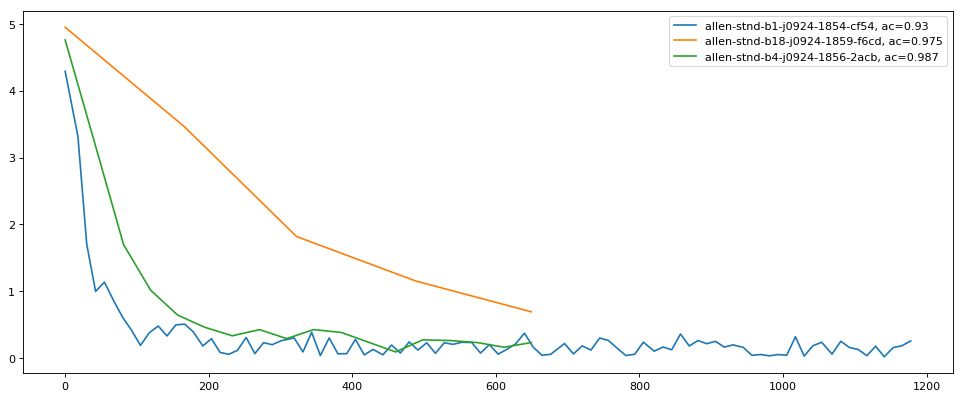

In [7]:

experiment_data = demo.event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-stnd-b*")
demo.show_experiment_loss(experiment_data)


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-24 19:28:29,743] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 8)


[2018-09-24 19:28:40,743] Processing experiment events (1 of 8)


INFO:tensorflow:Processing experiment events (2 of 8)


[2018-09-24 19:28:41,617] Processing experiment events (2 of 8)


INFO:tensorflow:Processing experiment events (3 of 8)


[2018-09-24 19:28:42,762] Processing experiment events (3 of 8)


INFO:tensorflow:Processing experiment events (4 of 8)


[2018-09-24 19:28:49,056] Processing experiment events (4 of 8)


INFO:tensorflow:Processing experiment events (5 of 8)


[2018-09-24 19:28:49,985] Processing experiment events (5 of 8)


INFO:tensorflow:Processing experiment events (6 of 8)


[2018-09-24 19:28:51,953] Processing experiment events (6 of 8)


INFO:tensorflow:Processing experiment events (7 of 8)


[2018-09-24 19:28:53,384] Processing experiment events (7 of 8)


INFO:tensorflow:Processing experiment events (8 of 8)


[2018-09-24 19:28:58,790] Processing experiment events (8 of 8)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-24 19:29:04,470] Finished loading event data for comparison.


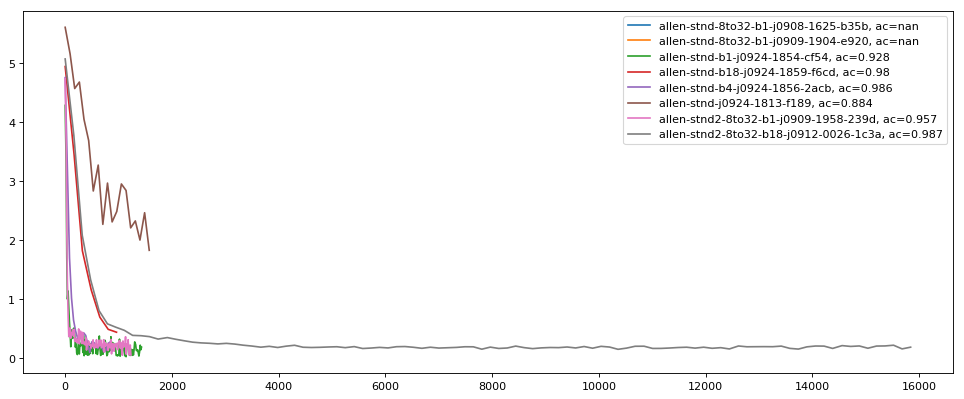

In [3]:

experiment_data = demo.event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-stnd*")
demo.show_experiment_loss(experiment_data)



Hmm so this appears to be behaving in a way similar to the previos runs that did not work.
Curious to take a look at predictions and the raw examples.


In [ ]:

args = demo.configure_experiment("allen-stnd-18",
                             problem="img2img_allen_brain_stnd",
                             num_gpu_per_worker=1,
                             hparams_set="img2img_transformer2d_tiny",
                             model="img2img_transformer",
                             extra_hparams={
                               "batch_size": 18,
                             },
                             num_steps=15000)

job = experiment.T2TExperiment(**args)
job.run()


In [2]:

from tensor2tensor.utils import trainer_lib
from tensor2tensor import problems
from tensor2tensor.utils import registry
import tensorflow as tf

Modes = tf.estimator.ModeKeys

hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

# No ckpts yet
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/allen-stnd-b18/allen-stnd-b18-j0924-1859-f6cd/output/model.ckpt-2262"
#ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/allen-stnd-b4/allen-stnd-b4-j0924-1856-2acb/output/model.ckpt-??"
#ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/allen-stnd-b1/allen-stnd-b1-j0924-1854-cf54/output/model.ckpt-??"


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-09-24 20:38:43,134] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-09-24 20:38:43,142] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-24 20:38:43,214] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-09-24 20:38:51,102] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-09-24 20:38:51,108] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-09-24 20:38:51,111] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-09-24 20:38:52,403] Transforming body output with identity_modality.top


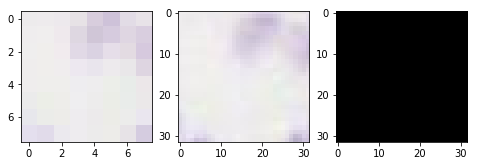

In [3]:
_ = demo.predict_ith(ckpt_path, dataset, model)

INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-09-24 20:09:33,356] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-24 20:09:33,433] partition: 0 num_data_files: 100


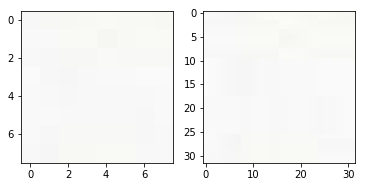

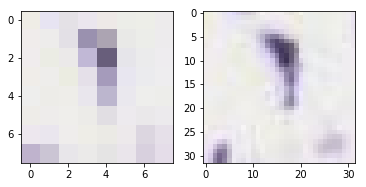

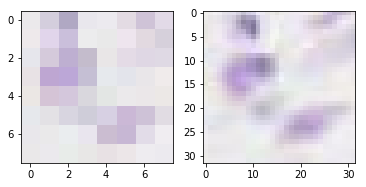

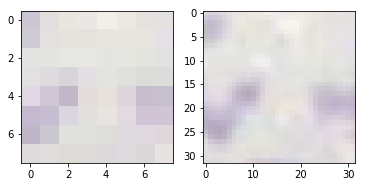

In [5]:

demo.show_random_examples(problem_object, data_dir, num=4)


In [8]:
# Standardization code

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes

def _Assert3DImage(image):
  """Assert that we are working with a properly shaped image.
    Performs the check statically if possible (i.e. if the shape
    is statically known). Otherwise adds a control dependency
    to an assert op that checks the dynamic shape.
    Args:
      image: 3-D Tensor of shape [height, width, channels]
    Raises:
      ValueError: if `image.shape` is not a 3-vector.
    Returns:
      If the shape of `image` could be verified statically, `image` is
      returned unchanged, otherwise there will be a control dependency
      added that asserts the correct dynamic shape.
    """
  return control_flow_ops.with_dependencies(
      _Check3DImage(image, require_static=False), image)

def _Check3DImage(image, require_static=True):
  """Assert that we are working with properly shaped image.
  Args:
    image: 3-D Tensor of shape [height, width, channels]
    require_static: If `True`, requires that all dimensions of `image` are
      known and non-zero.
  Raises:
    ValueError: if `image.shape` is not a 3-vector.
  Returns:
    An empty list, if `image` has fully defined dimensions. Otherwise, a list
    containing an assert op is returned.
  """
  try:
    image_shape = image.get_shape().with_rank(3)
  except ValueError:
    raise ValueError(
        "'image' (shape %s) must be three-dimensional." % image.shape)
  if require_static and not image_shape.is_fully_defined():
    raise ValueError("'image' (shape %s) must be fully defined." % image_shape)
  if any(x == 0 for x in image_shape):
    raise ValueError("all dims of 'image.shape' must be > 0: %s" % image_shape)
  if not image_shape.is_fully_defined():
    return [
        check_ops.assert_positive(
            array_ops.shape(image),
            ["all dims of 'image.shape' "
             'must be > 0.'])
    ]
  else:
    return []

def per_image_standardization(image):
  """Linearly scales `image` to have zero mean and unit norm.
  This op computes `(x - mean) / adjusted_stddev`, where `mean` is the average
  of all values in image, and
  `adjusted_stddev = max(stddev, 1.0/sqrt(image.NumElements()))`.
  `stddev` is the standard deviation of all values in `image`. It is capped
  away from zero to protect against division by 0 when handling uniform images.
  Args:
    image: 3-D tensor of shape `[height, width, channels]`.
  Returns:
    The standardized image with same shape as `image`.
  Raises:
    ValueError: if the shape of 'image' is incompatible with this function.
  """
  with ops.name_scope(None, 'per_image_standardization', [image]) as scope:
    image = ops.convert_to_tensor(image, name='image')
    image = _Assert3DImage(image)
    
    num_pixels = math_ops.reduce_prod(array_ops.shape(image))

    image = math_ops.cast(image, dtype=dtypes.float32)
    image_mean = math_ops.reduce_mean(image)

    variance = (
        math_ops.reduce_mean(math_ops.square(image)) -
        math_ops.square(image_mean))
    variance = gen_nn_ops.relu(variance)
    stddev = math_ops.sqrt(variance)

    # Apply a minimum normalization that protects us against uniform images.
    min_stddev = math_ops.rsqrt(math_ops.cast(num_pixels, dtypes.float32))
    pixel_value_scale = math_ops.maximum(stddev, min_stddev)
    pixel_value_offset = image_mean

    image = math_ops.subtract(image, pixel_value_offset)
    image = math_ops.div(image, pixel_value_scale, name=scope)
    return image
    

In [4]:

for i, example in enumerate(tfe.Iterator(dataset)):
    if i > 1234:
        break


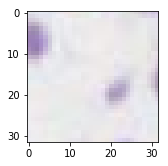

In [22]:

import matplotlib.pyplot as plt
import numpy as np

input_dim = 8
output_dim = 32

fig = plt.figure(figsize=(8, 8))

fig.add_subplot(1, 3, 2)
targets_raw = example["targets"]
targets_reshaped = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])

plt.imshow(targets_reshaped.numpy()[0])


In [23]:

orig = targets_reshaped.numpy()[0]
orig_mx = np.max(orig)
orig_mn = np.min(orig)
orig_mean = np.mean(orig)
orig_sd = np.std(orig)

print(orig_mx, orig_mn, orig_mean, orig_sd)


(247, 124, 228.30013020833334, 15.848559838085576)


In [24]:

std = per_image_standardization(targets_raw)
std_np = std.numpy()


[2018-09-24 20:17:33,111] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


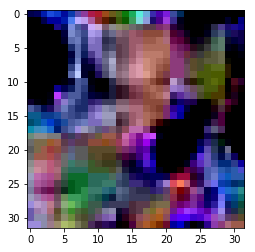

In [26]:
plt.imshow(std_np)

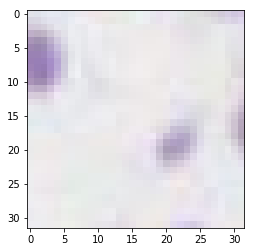

In [25]:

un_std = np.uint8((std_np * orig_sd) + orig_mean)

plt.imshow(un_std)


In [44]:

def infer(predictions):
    """Produce a predicted image using argmax of model-generated logits.
    
    Args:
        predictions (tf.Tensor): A 3-D tensor of logits.
    """
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.argmax(p[0][x][y][c])

    return image[0]


In [45]:

def predict_ith(ckpt_path, dataset, model, offset=1234, input_dim=8, output_dim=32, standardize=False):
    """Apply model to input obtained from dataset modulo offset.
    
    Args:
        offset (int): The offset within `dataset` where we will extract an example.
        ckpt_path (str): The path from which checkpoints will be loaded.
        dataset (`obj`): A tf.data dataset object.
        model (`obj`): A tensor2tensor model object loaded from the registry.
    """

    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
            
      orig_inputs = example["inputs"]
      orig_inputs_np = orig_inputs.numpy()[0]
      orig_mean = np.mean(orig_inputs_np)
      orig_sd = np.std(orig_inputs_np)
        
      if standardize:
        example["inputs"] = tf.image.per_image_standardization(example["inputs"])

      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(orig_inputs, [1, input_dim, input_dim, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, output_dim, output_dim, 3), dtype=np.uint8),
                                      [1, output_dim, output_dim, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      inferred = infer(predictions)
    
      inferred_unstd = (inferred * orig_sd) + orig_mean
    
      plt.imshow(np.uint8(inferred_unstd))
      plt.show()
        
    return example, predictions, inferred, inferred_unstd


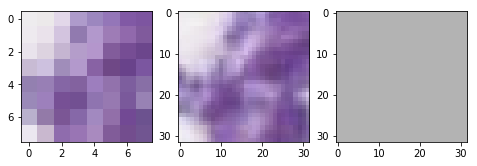

In [46]:

example, predictions, inferred, inferred_unstd = predict_ith(ckpt_path, dataset, model, standardize=True)


In [1]:

from tk import allen_brain

def PIL_Image():  # pylint: disable=invalid-name
  from PIL import Image  # pylint: disable=g-import-not-at-top
  return Image

tmp_dir = "/mnt/nfs-east1-d/tmp"

image_files = allen_brain._get_case_file_paths(tmp_dir=tmp_dir,
                                              case=True,
                                              training_fraction=0.95)

image_obj = PIL_Image()

allen_brain.maybe_compute_image_statistics(image_files)


Instructions for updating:
Use the retry module or similar alternatives.
Computing image statistics...
Processing image 1 of 693...
Found an existing metadata file...
Saw mean and stdev: 228.76187, 33.885197
Processing image 2 of 693...
Found an existing metadata file...
Saw mean and stdev: 227.1994, 38.684772
Processing image 3 of 693...
Found an existing metadata file...
Saw mean and stdev: 227.73842, 40.46309
Processing image 4 of 693...
Found an existing metadata file...
Saw mean and stdev: 237.2016, 26.115913
Processing image 5 of 693...
Found an existing metadata file...
Saw mean and stdev: 227.37161, 40.215828
Processing image 6 of 693...
Found an existing metadata file...
Saw mean and stdev: 231.50182, 33.601894
Processing image 7 of 693...
Found an existing metadata file...
Saw mean and stdev: 238.7187, 24.107862
Processing image 8 of 693...
Found an existing metadata file...
Saw mean and stdev: 226.52388, 38.498528
Processing image 9 of 693...
Found an existing metadata file.

(228.88863362193362, 36.05864959163059)